In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from src.estimate import sbm_slow, sbm_fast

In [ ]:
rng = np.random.default_rng(0)
# probs = np.array([
#     [0.9, 0.01, 0.01],
#     [0.01, 0.9, 0.01],
#     [0.01, 0.01, 0.9],
# ])
# probs = np.array([
#     [0.9, 0.9, 0.9],
#     [0.9, 0.9, 0.9],
#     [0.9, 0.9, 0.9],
# ])
probs = np.array([
    [0.4, 0.01, 0.01],
    [0.01, 0.4, 0.01],
    [0.01, 0.01, 0.4],
])
# probs = np.array([
#     [0.1, 0.0, 0.0],
#     [0.0, 0.1, 0.0],
#     [0.0, 0.0, 0.1],
# ])
# probs = np.array([
#     [0.4, 0.4, 0.01],
#     [0.4, 0., 0.01],
#     [0.01, 0.01, 0.42],
# ])
# sizes = rng.poisson(111, size=3)
# sizes = rng.poisson(555, size=3)
sizes = rng.poisson(1111, size=3)
graph = nx.stochastic_block_model(sizes, probs, seed=rng)
labels = [b for n, b in graph.nodes(data='block')]
num = sizes.shape[0]


In [ ]:
# from src import estimate
# estimate.VERBOSE = False
# %load_ext memory_profiler

In [ ]:
# %timeit sbm_slow(graph, 3, max_iter=100, tol=0)
# %memit sbm_slow(graph, 3, max_iter=100, tol=0)

In [ ]:
# %timeit sbm_fast(graph, 33, max_iter=100, tol=0, alpha=0.1)
# %timeit sbm_fast(graph, 3, max_iter=100, tol=0)
# %memit sbm_fast(graph, 3, max_iter=100, tol=0)

In [ ]:
# np.random.seed(0)
# seed = 123
# np.random.seed(seed)
# p1, t1 = sbm_slow(graph, 3, max_iter=100, track_scores=True, tol=0.)
# np.random.seed(seed)
# p2, t2 = sbm_fast(graph, 3, max_iter=100, track_scores=True, tol=0.)
# np.abs(p1-p2).mean(), np.abs(t1-t2).mean()

In [ ]:
pred = sbm_fast(graph, 3, alpha=0.25, tol=0.01)

In [ ]:
plt.plot(pred);

In [ ]:
pred, scores = sbm_fast(graph, 3, alpha=0.01, tol=0.01, track_scores=True)

In [ ]:
plt.plot(scores);

---

In [1]:
import numpy as np
from src.estimate import *

# This approach implements the method with more computational efficiency
def sbm_fast(G, k, *,
             likelihood='bernoulli',
             alpha=0.,
             weight=None,
             track_scores=False,
             max_iter=100,
             min_epochs=10,
             tol=0.01):

    track_scores = True

    ## Adjacency matrix ##
    A = nx.to_scipy_sparse_array(G, weight=weight).astype(float)
    A_dense = A.toarray() if track_scores else None
    n_nodes = len(G.nodes)

    if likelihood == 'bernoulli':
        assert ((A.data==0) | (A.data==1)).all()
    elif likelihood == 'poisson':
        assert (A.data >= 0).all() and (A.data == A.data.round()).all()
    elif likelihood == 'normal':
        pass
    else:
        raise ValueError

    ## Soft partition matrix ##
    X = np.ones((n_nodes, k)) / k
    X += np.random.randn(n_nodes, k) / 100
    ## Hard partition matrix ##
    partition = X.argmax(1)
    Z = csr_array((np.ones(n_nodes), (np.arange(n_nodes), partition)),
                  shape=X.shape, dtype=X.dtype)

    ## Structure matrix sufficient statistics ##
    M = Z.T @ (A @ Z)
    n = Z.sum(0)[:, None]
    ## Structure matrix MLE ##
    B = M.toarray() / (n@n.T).clip(1, None)

    ## Regularization ##
    R = np.eye(k) * alpha

    if track_scores:
        vprint('tracking scores may significantly increase runtime')
        ## Initialize trace of scores ##
        P = np.clip(Z@B@Z.T, EPS, 1-EPS)
        if likelihood == 'bernoulli':
            L = A_dense * np.log(P) + (1-A_dense) * np.log(1-P)
        elif likelihood == 'poisson':
            L = A_dense * np.log(P) - P
        elif likelihood == 'normal':
            L = 1/2 * (A_dense - P)**2
        trace = [L.mean()]

    history = []
    history.append((X.copy(), Z.toarray().copy(), L.mean()))

    for epoch in range(max_iter):

        ## Compute predictions ##
        if likelihood == 'bernoulli':
            w_pre = 1 / (B * (1 - B)).clip(EPS, None)
        elif likelihood == 'poisson':
            w_pre = 1 / B.clip(EPS, None)
        elif likelihood == 'normal':
            w_pre = np.ones_like(B)
        w_block = (w_pre * n.T).sum(axis=1) / n.sum()
        w = w_block[partition]

        ## Perform fisher scoring updates ##
        # ZB = B.T[partition, :]
        ZB = Z @ B.T
        ZBW = ZB * w[:, None]
        hess = ZB.T @ ZBW + R
        # grad = ZBW.T @ A
        grad = (A.T @ ZBW).T
        X = (X - Z) + np.linalg.solve(hess, grad).T

        ## Update partition ##
        prev_partition = partition
        partition = X.argmax(1)

        ## Recompute structure matrix ##
        Z.indices[:], Z.data[:] = partition, 1
        # Z.indices[:] = partition
        # Z.data[:] = 1
        M = Z.T @ (A @ Z)
        n = Z.sum(0)[:, None]
        B = M.toarray() / (n@n.T).clip(1, None)

        ## Early stopping ##
        if epoch > min_epochs and (prev_partition == partition).mean() > 1-tol:
            vprint('converged in', epoch+1, 'iterations')
            break

        ## Append current score to trace ##
        if track_scores:
            P = np.clip(Z@B@Z.T, EPS, 1-EPS)
            if likelihood == 'bernoulli':
                L = A_dense * np.log(P) + (1-A_dense) * np.log(1-P)
            elif likelihood == 'poisson':
                L = A_dense * np.log(P) - P
            elif likelihood == 'normal':
                L = 1/2 * (A_dense - P)**2
            trace.append(L.mean())
        history.append((X.copy(), Z.toarray().copy(), L.mean()))

    else:
        vprint('did not converge after', max_iter, 'iterations')

    return history


In [22]:
rng = np.random.default_rng(0)
# probs = np.array([
#     [0.25, 0.001, 0.001],
#     [0.001, 0.25, 0.001],
#     [0.001, 0.001, 0.25],
# ])
probs = np.array([
    [0.4, 0.01, 0.01],
    [0.01, 0.4, 0.01],
    [0.01, 0.01, 0.4],
])
sizes = rng.poisson(111, size=3)
graph = nx.stochastic_block_model(sizes, probs, seed=rng)
labels = [b for n, b in graph.nodes(data='block')]
num = sizes.shape[0]

In [38]:
history = sbm_fast(graph, 3, max_iter=25, alpha=0.01, tol=0.0)
history[-1][0].argmax(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [39]:
X_hist = [h[0] for h in history]
Z_hist = [h[1] for h in history]
scores = [h[2] for h in history]
smin, smax = min(scores), max(scores)
srange = smax-smin
smin, smax = smin-(smax-smin)/10, smax+(smax-smin)/10

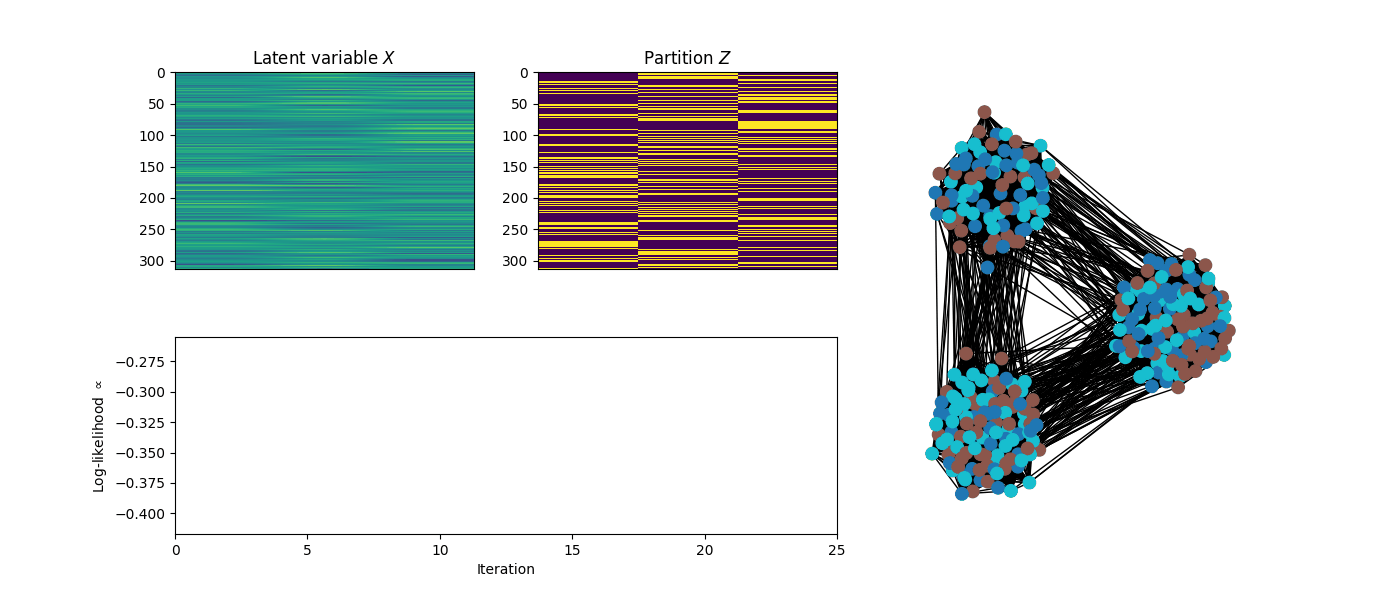

In [40]:
# ChatGPT:

from IPython.display import Image as IPImage
import numpy as np
import networkx as nx
from IPython.display import clear_output, display
from PIL import Image
import matplotlib.pyplot as plt

# Required variables from previous cells: X_hist, Z_hist, scores, graph
n_steps = len(X_hist)

# fixed layout for reproducibility; compute once
pos = nx.spring_layout(graph, seed=0)

# collect frames (RGB uint8 arrays)
frames = []

# single updating display using clear_output so only one figure is shown
for i in range(n_steps):
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1.2], height_ratios=[1, 1], hspace=0.35)

    # Left: top row has X and Z side-by-side
    ax_X = fig.add_subplot(gs[0, 0])
    ax_Y = fig.add_subplot(gs[0, 1])
    # Right: graph spans both rows
    ax_graph = fig.add_subplot(gs[:, 2])
    # Bottom: scores span left two columns
    ax_score = fig.add_subplot(gs[1, 0:2])

    # X and Z images for this step
    ax_X.imshow(X_hist[i], aspect='auto')
    ax_X.set_title('Latent variable $X$')
    ax_X.set_xticks([])

    ax_Y.imshow(Z_hist[i], aspect='auto', interpolation='none')
    ax_Y.set_title('Partition $Z$')
    ax_Y.set_xticks([])

    # Scores up to this step
    xs = np.arange(i + 1)
    ys = np.array(scores[: i + 1])
    ax_score.plot(xs, ys, color='C1')
    ax_score.set_xlim(0, max(1, n_steps - 1))
    ax_score.set_ylim([smin, smax])
    ax_score.set_ylabel('Log-likelihood $\propto$')
    ax_score.set_xlabel('Iteration')

    # Graph colored by partition at this step
    partition = np.array(Z_hist[i]).argmax(1)
    nx.draw(graph, pos=pos, node_color=partition, cmap='tab10', ax=ax_graph, with_labels=False, node_size=80)

    # draw and capture frame
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape((h, w, 3))
    frames.append(img)

    # show only the latest figure in the notebook output
    # clear_output(wait=True)
    # display(fig)
    # plt.pause(0.05)
    plt.close(fig)

# after loop, write gif to disk if possible
out_path = 'sbm_animation.gif'
imgs = [Image.fromarray(f) for f in frames]
imgs[0].save(out_path, save_all=True, append_images=imgs[1:], duration=100, loop=0)

clear_output(wait=True)
display(IPImage(filename=out_path))
